In [1]:
%load_ext autoreload
%autoreload 2

# Problem and Solution
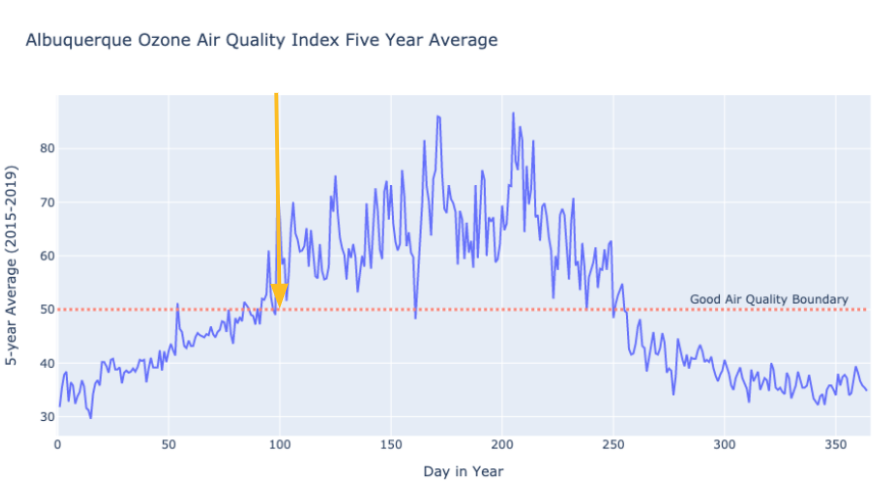
The air quality of ABQ starts to decrease from mid april, meaning getting as many polluting vehicles as possible off the road before day-100 is critical to increase air quality in ABQ. 


The solution is that using a classification algorithm to predict how likely a vehicle fail the inspection and schedule earlier test dates for vehicles that are more likely fail the test. Here is the work flow of this solution.
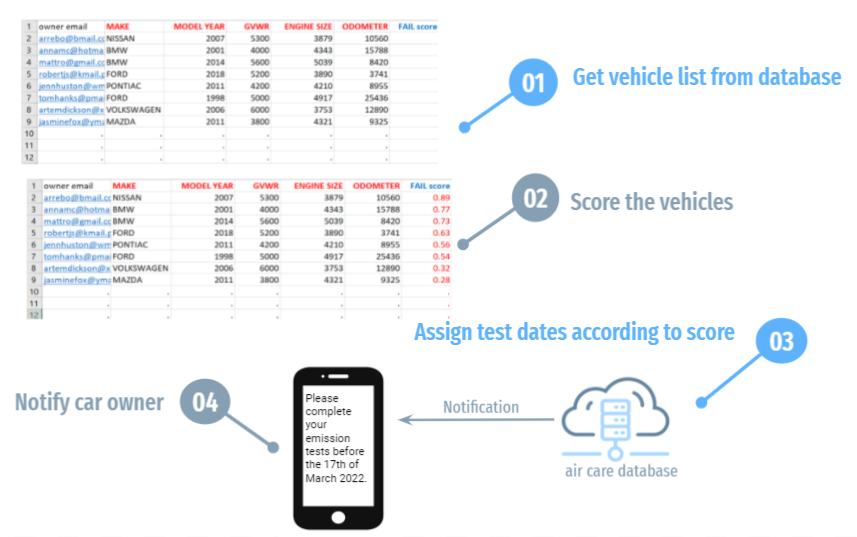


# Data Preparation

Random sampled 10% data to continue since we didn’t have paid cloud service.

## data cleaning
1. Because the vehicles that failed the test can receive free retest within 90 days, we kept only the earliest testing record within 90 days for each vehicle. 
2. Some vehicles have multiple values for Gross Vehicle Weight, therefore we took the median weight for each vehicle.
3. As mechanical odometers often have weird values like 8888 or 9999 when they are broken. Those records, along with some outliers, were removed from dataset.

## feature engineering
1. Age of vehicle. The distribution of which was clearly different for two target classes
2. Miles per Year. Because the cars used more frequently are more likely to fail the test due to reasons like dirty air filter or worn-down spark plugs.
3. Engine Weight Ratio. Considering the sport cars often cause lots of pollution and they tend to have larger engine, we engineered this feature.
4. Make. Grouped the makes that occurred in less than 1% of data to “other”. To prevent data leakage, custom Make transformer was used. 

Check emissions/data.py and emissions/transformer.py for more details on cleaning and feature engineering.

## train, val and test split
- Training set: data before 2019
- Validation set: 2019 data
- Test set: 2020 data

Here we split the data with time order considering the nature of our custom performance metric, see below

In [2]:
from emissions.impsearch import ImpSearch
imp = ImpSearch()
imp.load_data()

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 165732

Records where ODOMETER = 0: 796

Records after droping rows where ODOMETER is missing: 164855

Records after droping rows where MILE_YEAR > 40,000: 163891

Records in output data:163891

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10194
Unique vehicles in Pass: 78573


# Baseline Performance

Used a heuristic method  for baseline, which is that all vehicles with age older than 16 will fail the emissions test and older vehicles are more likely fail the test. 

We chose 16 because near 75% vehicles that passed the test were newer than 16 years old while ~50% of vehicles failed the test were older than 16 years.



# Custom Performance Metric

1. While keeping the testing speed of test centers same as before, we need to get as many test-failing vehicles as possible off the road before mid April, meaning we need a high precision.

2. Meanwhile we also don’t want to miss out too many polluting vehicles in our early testing schedule. This means the recall shouldn't be too low.

**Custom Performance Metric**
the average on-road Days Per Failing Vehicle in an entire year (DPFV)



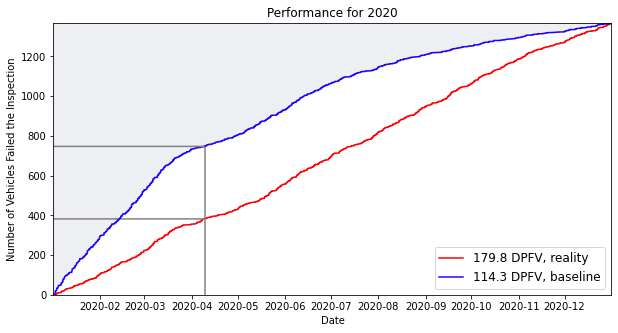

,DPFV,Number of Polluting Vehicles off the road by day 100
reality,179.8,382
heuristic,114.3,747


In [3]:
imp.evaluate_baseline(2020)

- The red line represents the cumulative number of vehicles that failed the emissions test in 2020. 
- In 2020, there are total of 1368 vehicles failed emissions tests. 
- By 9th April 382 vehicles failed the test, meaning the remaining  ~ 900 test-failing vehicles were still on the road. 
- What could have happened if we had used our baseline model to schedule earlier test dates for vehicles older than 16 years in 2020. That is the blue line here. 

- By the same date, we could have brought 747 test-failing for inspection, reducing the total on-road days of test-failing vehicles. 

# Custom GridSearch
For each value in a list of given max_depth values, it trains the RF using that max_depth value, implements the solution for 2019 and calculates the DPFV. The best max_depth is the one that gave the smallest DPFV.


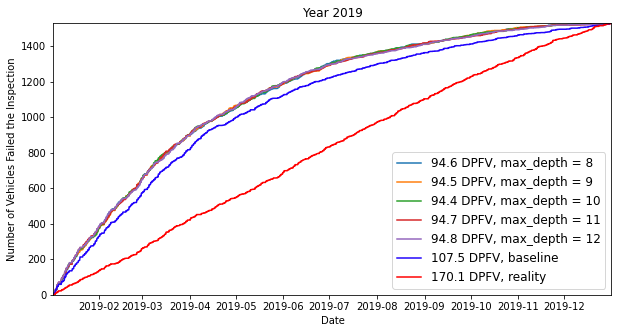

,DPFV,Number of Polluting Vehicles off the road by day 100
max_depth,,
10,94.4,961
9,94.5,958
8,94.6,951
11,94.7,964
12,94.8,962
heuristic,107.5,900
reality,170.1,460


In [4]:
import numpy as np
imp.get_best_max_depth(2019, n_estimators=[100], max_depth=np.arange(8, 13, 1))

# Random Forest Outperforms Baseline


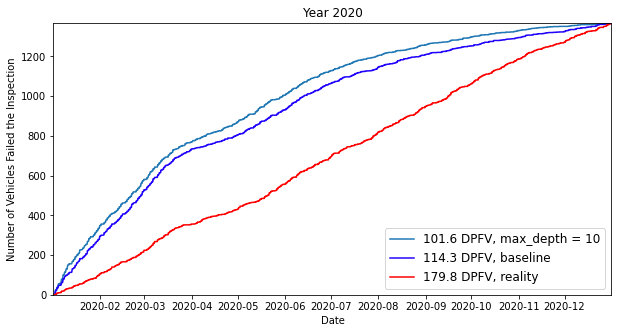

In [8]:
df = imp.evaluate_RF(2020)

In [12]:
total_failing_cars_2020 = imp.total_fails
df['% of test-failing vehicles off the road by day 100'] = \
    100.0*df['Number of Polluting Vehicles off the road by day 100']/total_failing_cars_2020
round(df, 2)

,DPFV,Number of Polluting Vehicles off the road by day 100,% of test-failing vehicles off the road by day 100
max_depth,,,
10,101.6,798,58.33
heuristic,114.3,747,54.61
reality,179.8,382,27.92


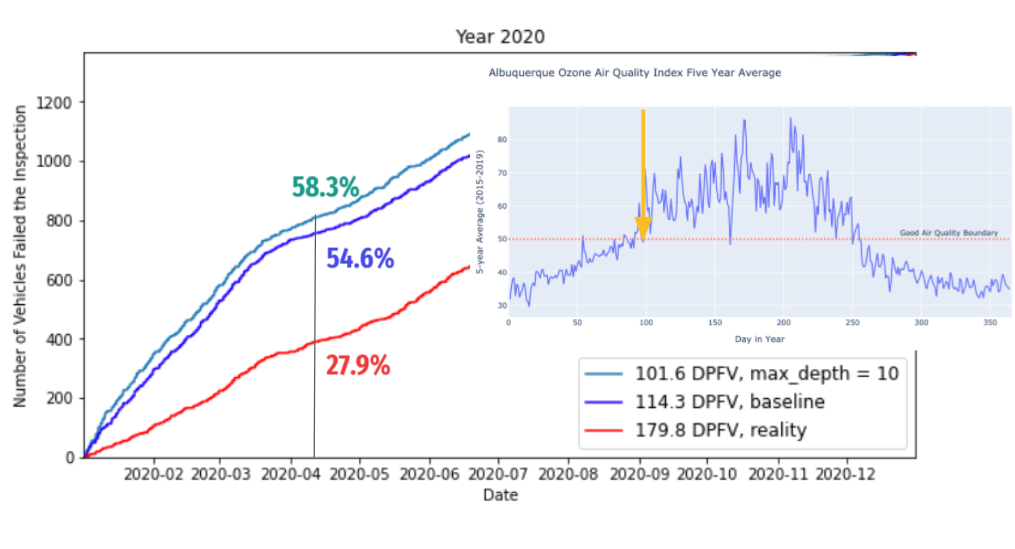
Random Forest outperformed the baseline by 
- reducing the average polluting days per test-failing vehicle from 114 to 102
- getting additional 4% of test-failing vehicles off the road by day-100

**🚀Our solution is able to get almost 60% of test-failing vehicles off the road before the air quality of ABQ starts to drop**

